In [1]:
import os
import time
import random
import math

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from transformers import BertModel
from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertDataset, MLMDataset
from causal_bert import CausalBert

In [12]:
bsz = 16
epoch = 10
hidden_size = 64
lr = 5e-6

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert effect == 'ate' and estimation == 'q', f'unallowed effect/estimation: {effect}/{estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_scores.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi
        
def est_casual_effect(data_loader, model, effect='ate', estimation='q', evaluate=True, **kwargs):
    # We use `real_treatment` here to emphasize the estimations use real instead of estimated treatment.
    real_response, real_treatment, real_prop_scores = [], [], []
    prop_scores, Q1, Q0 = [], [], []
    
    if evaluate:
        g_loss = kwargs.get('g_loss')
        q_loss = kwargs.get('q_loss')
        g_loss_test, q1_loss_test, q0_loss_test  = [], [], []
        
    model.eval()
    for idx, (tokens, treatment, response, real_prop_score) in enumerate(data_loader):
        real_response.append(response.cpu().data.numpy().squeeze())
        real_treatment.append(treatment.cpu().data.numpy().squeeze())
        real_prop_scores.append(real_prop_score.cpu().data.numpy().squeeze())

        prop_score, q1, q0 = model(tokens)
        
        prop_scores.append(prop_score.cpu().data.numpy().squeeze())
        Q1.append(q1.cpu().data.numpy().squeeze())
        Q0.append(q0.cpu().data.numpy().squeeze())
        
        # Evaulate loss
        if evaluate:
            g_loss_val  = g_loss(prop_score, treatment)
            g_loss_test.append(g_loss_val.item())
            if len(response[treatment == 1]) > 0:
                q1_loss_val = q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
                q1_loss_test.append(q1_loss_val.item())

            if len(response[treatment == 0]) > 0:
                q0_loss_val = q_loss(q0[treatment==0], response[treatment==0])
                q0_loss_test.append(q0_loss_val.item())
    
    g_loss = np.array(g_loss_test).mean() if evaluate else None
    q1_loss = np.array(q1_loss_test).mean() if evaluate else None
    q0_loss = np.array(q0_loss_test).mean() if evaluate else None

    Q1 = np.concatenate(Q1, axis=0)
    Q0 = np.concatenate(Q0, axis=0)
    prop_scores = np.concatenate(prop_scores, axis=0)
    
    real_response = np.concatenate(real_response, axis=0)
    real_treatment = np.concatenate(real_treatment, axis=0)
    real_prop_scores = np.concatenate(real_prop_scores, axis=0)
    
    # Evaluate accuracy.
    if evaluate:
        dataset = data_loader.dataset
        
        real_q1_prob = sigmoid(dataset.alpha + dataset.beta * (real_prop_scores - dataset.c) + dataset.i)
        real_q0_prob = sigmoid(dataset.beta * (real_prop_scores - dataset.c) + dataset.i)
        thre = (real_q1_prob + real_q0_prob) / 2

    # prop score: real and estimated must locate one the same side of 0.5.
    prop_accu = (1. * (((real_prop_scores - .5) * (prop_scores - .5)) > 0.)).mean() if evaluate else None
    # q: estimate is more close to corresponding real value than the other.
    q1_accu = (1. * (dataset.alpha > 0) * (Q1 > thre)).mean() if evaluate else None
    q0_accu = (1. * (dataset.alpha > 0) * (Q0 < thre)).mean() if evaluate else None


    if estimation == 'q':
        if effect == 'att':
            phi = (real_treatment * (Q1 - Q0))
            effect = phi.sum() / real_treatment.sum()
        elif effect == 'ate':
            effect = (Q1 - Q0).mean()

    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            effect = phi / real_treatment.mean()
        elif effect == 'ate':
            effect = phi
    
    model.train()

    return effect, g_loss, q1_loss, q0_loss, prop_accu, q1_accu, q0_accu

def show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch):
    train_loss_hist = np.array(train_loss_hist)
    test_loss_hist = np.array(test_loss_hist)
    est_effect = np.array(est_effect)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lns1 = ax.plot(np.arange(epoch), test_loss_hist, label='Eval loss')
    ax_r = plt.twinx()
    lns2 = ax_r.plot(np.arange(epoch), est_effect, color='coral', label='Estimate ATE')
    lns3 = ax_r.plot(np.arange(epoch), np.ones(epoch) * real, color='red', ls='--', label='Real ATE')
    lns4 = ax_r.plot(np.arange(epoch), np.ones(epoch) * unadjust, color='green', ls='--', label='Unadjusted ATE')

    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    ax_r.legend(lns, labs, loc=0)
    ax.set_ylabel('Eval loss')
    ax_r.set_ylabel('ATEs')

    plt.show()
    

# LOW

In [5]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

alpha = 0.25
beta = 1.
c = 0.2
i = 0.

In [6]:
start = time.time()
trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                             alpha=alpha, beta=beta, c=c, i=i, 
                             group=list(range(1)), max_length=512, min_length=10,
                             truncate_method='first', device=device, seed=1)

print(f'Load training set in {(time.time() - start):.2f} sec')

start = time.time()
testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                            alpha=alpha, beta=beta, c=c, i=i, 
                            group=[9], max_length=512, min_length=10,
                            truncate_method='first', device=device)

print(f'Load validation set in {(time.time() - start):.2f} sec')

Load training set in 78.14 sec
Load validation set in 67.77 sec


In [7]:
train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, batch_size=bsz, drop_last=True, shuffle=True)

In [8]:
real_att_q = true_casual_effect(test_loader)

print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

Real: [effect: ate], [estimation: q], [value: 0.06317]
Unadjusted: [value: 0.0919]


In [13]:
trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'


bert = BertModel.from_pretrained(trained_bert).to(device)
model = CausalBert(bert, learnable_docu_embed=False, hidden_size=hidden_size, prop_is_logit=True).to(device)

pos_portion = trainset.treatment.mean()
pos_weight = (1 - pos_portion) / pos_portion

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epoch_iter = len(train_loader)
total_steps = epoch * epoch_iter

optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps // 2, num_training_steps=total_steps)

q_loss = nn.BCELoss()
# prop_score_loss = nn.BCELoss()
prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Please specify the effect and estimation we want to use here.
effect = 'ate'
estimation = 'q'

effect = effect.lower()
estimation = estimation.lower()
assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [14]:
train_loss_hist, test_loss_hist, est_effect = [], [], []
for e in range(1, 11):
    model.train()
    start = time.time()
    run_loss = 0.
    for idx, (tokens, treatment, response, _) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss = prop_score_loss(prop_score, treatment)
        if len(response[treatment == 1]) > 0:
            loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
        if len(response[treatment == 0]) > 0:
            loss += q_loss(q0[treatment==0], response[treatment==0])
            
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        optimizer.step()
        scheduler.step()

        run_loss += loss.item()
        
    run_idx = idx

    # Evaluation.
    train_loss = run_loss / (run_idx + 1)
    #train_effect, _, _, _, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, evaluate=False)
    test_effect, g_loss_test, q1_loss_test, q0_loss_test, prop_accu_test, q1_accu_test, q0_accu_test = est_casual_effect(test_loader, model, effect, estimation, evaluate=True, g_loss=prop_score_loss, q_loss=q_loss)
    test_loss = q1_loss_test + q0_loss_test
    test_loss += g_loss_test
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    est_effect.append(test_effect)
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
          Accuracy: [prop score: {prop_accu_test: .5f}], [q1: {q1_accu_test:.5f}], [q0: {q0_accu_test:.5f}],
          Effect: [{effect}-{estimation}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()
    run_loss = 0.

print('Finish training...')
 
# With only 1 group(s) to train.

epoch: 1 / 10, time cost: 1791.86 sec, 
          Loss: [Train: 2.41433], [Test: 2.39481],
          Accuracy: [prop score:  0.93113], [q1: 0.93627], [q0: 0.99322],
          Effect: [ate-q], [test: 0.06107]
********************************************************************************
epoch: 2 / 10, time cost: 1791.65 sec, 
          Loss: [Train: 2.35909], [Test: 2.35150],
          Accuracy: [prop score:  0.99703], [q1: 0.93649], [q0: 0.99995],
          Effect: [ate-q], [test: 0.07055]
********************************************************************************
epoch: 3 / 10, time cost: 1799.76 sec, 
          Loss: [Train: 2.33116], [Test: 2.34239],
          Accuracy: [prop score:  0.99977], [q1: 0.99887], [q0: 0.99985],
          Effect: [ate-q], [test: 0.06693]
********************************************************************************
epoch: 4 / 10, time cost: 1818.07 sec, 
          Loss: [Train: 2.32863], [Test: 2.34291],
          Accuracy: [prop score:  0.99983]

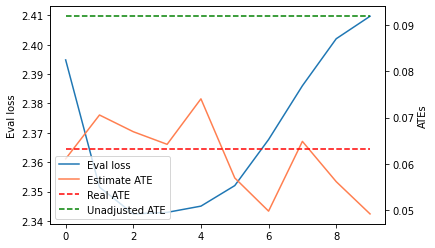

In [15]:
real = true_casual_effect(test_loader)
unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)

# 11 - 20 epoch

In [ ]:
for e in range(11, 21):
    model.train()
    start = time.time()
    run_loss = 0.
    for idx, (tokens, treatment, response, _) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss = prop_score_loss(prop_score, treatment)
        if len(response[treatment == 1]) > 0:
            loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
        if len(response[treatment == 0]) > 0:
            loss += q_loss(q0[treatment==0], response[treatment==0])
            
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        optimizer.step()
        scheduler.step()

        run_loss += loss.item()
        
    run_idx = idx

    # Evaluation.
    train_loss = run_loss / (run_idx + 1)
    #train_effect, _, _, _, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, evaluate=False)
    test_effect, g_loss_test, q1_loss_test, q0_loss_test, prop_accu_test, q1_accu_test, q0_accu_test = est_casual_effect(test_loader, model, effect, estimation, evaluate=True, g_loss=prop_score_loss, q_loss=q_loss)
    test_loss = q1_loss_test + q0_loss_test
    test_loss += g_loss_test
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    est_effect.append(test_effect)
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
          Accuracy: [prop score: {prop_accu_test: .5f}], [q1: {q1_accu_test:.5f}], [q0: {q0_accu_test:.5f}],
          Effect: [{effect}-{estimation}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()
    run_loss = 0.

print('Finish training...')

# With only 1 group(s) to train.

In [ ]:
real = true_casual_effect(test_loader)
unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)

# Med

In [ ]:
# vocab = create_vocab(merged=True, uni_diag=True)
# tokenizer = WordLevelBertTokenizer(vocab)

# alpha = 0.25
# beta = 5.
# c = 0.2
# i = 0.

In [ ]:
# start = time.time()
# trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
#                              alpha=alpha, beta=beta, c=c, i=i, 
#                              group=list(range(1)), max_length=512, min_length=10,
#                              truncate_method='first', device=device, seed=1)

# print(f'Load training set in {(time.time() - start):.2f} sec')

# start = time.time()
# testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
#                             alpha=alpha, beta=beta, c=c, i=i, 
#                             group=[9], max_length=512, min_length=10,
#                             truncate_method='first', device=device)

# print(f'Load validation set in {(time.time() - start):.2f} sec')

In [ ]:
# train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
# test_loader = DataLoader(testset, batch_size=2048, drop_last=True, shuffle=True)

In [ ]:
# real_att_q = true_casual_effect(test_loader)

# print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
# print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

In [ ]:
# trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# # trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'

# model = BertForMaskedLM.from_pretrained(trained_bert)
# token_embed = model.get_input_embeddings()
# model = CausalBOW(token_embed, learnable_docu_embed=False, hidden_size=hidden_size, prop_is_logit=True).to(device)

# pos_portion = trainset.treatment.mean()
# pos_weight = (1 - pos_portion) / pos_portion

# # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# epoch_iter = len(train_loader)
# total_steps = epoch * epoch_iter

# optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps // 2, num_training_steps=total_steps)

# q_loss = nn.BCELoss()
# # prop_score_loss = nn.BCELoss()
# prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Please specify the effect and estimation we want to use here.
# effect = 'ate'
# estimation = 'q'

# effect = effect.lower()
# estimation = estimation.lower()
# assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
# assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [ ]:
# rs_loss, rq1_loss, rq0_loss = [0.] * 3

# train_loss_hist, test_loss_hist, est_effect = [], [], []
# for e in range(1, epoch + 1):
#     model.train()
#     start = time.time()
#     run_loss = 0.
#     for idx, (tokens, treatment, response, _) in enumerate(train_loader):
#         optimizer.zero_grad()
#         prop_score, q1, q0 = model(tokens)
        
#         loss = prop_score_loss(prop_score, treatment)
#         if len(response[treatment == 1]) > 0:
#             loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
#         if len(response[treatment == 0]) > 0:
#             loss += q_loss(q0[treatment==0], response[treatment==0])
            
#         loss.backward()
        
# #         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
#         optimizer.step()
#         scheduler.step()

#         run_loss += loss.item()
        
#     run_idx = idx

#     # Evaluation.
#     train_loss = run_loss / (run_idx + 1)
#     train_effect, _, _, _, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, evaluate=False)
#     test_effect, g_loss_test, q1_loss_test, q0_loss_test, prop_accu_test, q1_accu_test, q0_accu_test = est_casual_effect(test_loader, model, effect, estimation, evaluate=True, g_loss=prop_score_loss, q_loss=q_loss)
#     test_loss = q1_loss_test + q0_loss_test
#     test_loss += g_loss_test
    
#     train_loss_hist.append(train_loss)
#     test_loss_hist.append(test_loss)
#     est_effect.append(test_effect)
#     print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
#           Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
#           Accuracy: [prop score: {prop_accu_test: .5f}], [q1: {q1_accu_test:.5f}], [q0: {q0_accu_test:.5f}],
#           Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
#     print('*'* 80)
#     start = time.time()
#     run_loss = 0.

# print('Finish training...')

# # With only 1 group(s) to train.

In [ ]:
# real = true_casual_effect(test_loader)
# unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
# show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)

# High

In [ ]:
# vocab = create_vocab(merged=True, uni_diag=True)
# tokenizer = WordLevelBertTokenizer(vocab)

# alpha = 0.75
# beta = 25.
# c = 0.2
# i = 0.

In [ ]:
# start = time.time()
# trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
#                              alpha=alpha, beta=beta, c=c, i=i, 
#                              group=list(range(1)), max_length=512, min_length=10,
#                              truncate_method='first', device=device, seed=1)

# print(f'Load training set in {(time.time() - start):.2f} sec')

# start = time.time()
# testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
#                             alpha=alpha, beta=beta, c=c, i=i, 
#                             group=[9], max_length=512, min_length=10,
#                             truncate_method='first', device=device)

# print(f'Load validation set in {(time.time() - start):.2f} sec')

In [ ]:
# train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
# test_loader = DataLoader(testset, batch_size=2048, drop_last=True, shuffle=True)

In [ ]:
# real_att_q = true_casual_effect(test_loader)

# print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
# print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

In [ ]:
# trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# # trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'

# model = BertForMaskedLM.from_pretrained(trained_bert)
# token_embed = model.get_input_embeddings()
# model = CausalBOW(token_embed, learnable_docu_embed=False, hidden_size=hidden_size, prop_is_logit=True).to(device)

# pos_portion = trainset.treatment.mean()
# pos_weight = (1 - pos_portion) / pos_portion

# # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# epoch_iter = len(train_loader)
# total_steps = epoch * epoch_iter

# optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps // 2, num_training_steps=total_steps)

# q_loss = nn.BCELoss()
# # prop_score_loss = nn.BCELoss()
# prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# # Please specify the effect and estimation we want to use here.
# effect = 'ate'
# estimation = 'q'

# effect = effect.lower()
# estimation = estimation.lower()
# assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
# assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [ ]:
# rs_loss, rq1_loss, rq0_loss = [0.] * 3

# train_loss_hist, test_loss_hist, est_effect = [], [], []
# for e in range(1, epoch + 1):
#     model.train()
#     start = time.time()
#     run_loss = 0.
#     for idx, (tokens, treatment, response, _) in enumerate(train_loader):
#         optimizer.zero_grad()
#         prop_score, q1, q0 = model(tokens)
        
#         loss = prop_score_loss(prop_score, treatment)
#         if len(response[treatment == 1]) > 0:
#             loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
#         if len(response[treatment == 0]) > 0:
#             loss += q_loss(q0[treatment==0], response[treatment==0])
            
#         loss.backward()
        
# #         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
#         optimizer.step()
#         scheduler.step()

#         run_loss += loss.item()
        
#     run_idx = idx

#     # Evaluation.
#     train_loss = run_loss / (run_idx + 1)
#     train_effect, _, _, _, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, evaluate=False)
#     test_effect, g_loss_test, q1_loss_test, q0_loss_test, prop_accu_test, q1_accu_test, q0_accu_test = est_casual_effect(test_loader, model, effect, estimation, evaluate=True, g_loss=prop_score_loss, q_loss=q_loss)
#     test_loss = q1_loss_test + q0_loss_test
#     test_loss += g_loss_test
    
#     train_loss_hist.append(train_loss)
#     test_loss_hist.append(test_loss)
#     est_effect.append(test_effect)
#     print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
#           Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
#           Accuracy: [prop score: {prop_accu_test: .5f}], [q1: {q1_accu_test:.5f}], [q0: {q0_accu_test:.5f}],
#           Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
#     print('*'* 80)
#     start = time.time()
#     run_loss = 0.

# print('Finish training...')

# # With only 1 group(s) to train.

In [ ]:
# real = true_casual_effect(test_loader)
# unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
# show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)